### <img src="https://www.dropbox.com/s/l93ecugg1jbtjiw/fga.png?raw=1" width="1200" height="400">

<ul>
    <li> <b>Campus UnB Gama</b> </li>
    <li> <b>Disciplina: Processamento Digital de Sinais Financeiros</b></li> 
    <li>
     Prof. Marcelino Monteiro de Andrade Dr.</li>
</ul> 
    
    Segunda (2/3) Atividade Prática Avaliativa - Algo Trading
    Entrega da Atividade 31/08/2022 
    "A não entrega na data esperada reduz em 50% na nota da avaliação"


<div id="Tópicos">
<h2>Questões</h2>
&ensp;
    <ol> 
        <li>Implemente uma estratégia de trade automático baseado em duas médias móveis. Utilize um período mínimo de 3 anos, otimize nos dois primeiros anos e aplique no terceiro. Aproveite os ativos escolhidos na primeira avaliação, considere um capital de R$\100.000,00 e as taxas envolvidas na operação.</a></li>&ensp;
        <li>Implemente uma estratégia de trade automático baseado em duas médias móveis anteriores, adicionando à aplicação o RSI ou MACD. Utilize um período mínimo de 3 anos, otimize nos dois primeiros anos e aplique no terceiro. Aproveite os ativos escolhidos na questão 1.</a></li>&ensp;
        <li>Escolha uma estratégia de trade automático de contra tendência, apresentada na Referência Palex. Utilize um período mínimo de 3 anos, otimize nos dois primeiros anos e aplique no terceiro. Aplique nos ativos escolhidos na questão 1.</a></li>&ensp;
        <li>Compare os resultados das três estratégias de trades, quanto: a) Retorno de Capital, b) Número de Trades, c) Taxa de Acertos, d) Fator de Lucro, e) Índice Sharpe e o f) retorno dos ativos avaliados na condição buy&hold e com relação ao índice bovespa.</a></li>&ensp;
        <li>Observação: caso a equipe tenha o interesse em avaliar outras estratégias de algo trading e bem vindo também!</a></li>&ensp;        
</ol>
</div>



In [10]:

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from tqdm import tqdm
import investpy
import matplotlib.dates as mdates
from scipy import signal
import random
import math

import warnings as wrn
wrn.filterwarnings('ignore', category = DeprecationWarning) 
wrn.filterwarnings('ignore', category = FutureWarning) 
wrn.filterwarnings('ignore', category = UserWarning)


def sumper(per):
    persum=100*(np.exp(np.log1p(per/100).cumsum())-1)
    return persum

In [11]:
stocks=['B3SA3','MGLU3','PRIO3', 'JBSS3']

out_otim = None

for stk in tqdm(stocks):

    df_otim = investpy.get_stock_historical_data(stock=stk,
                                            country='Brazil',
                                            from_date='16/11/2018',
                                            to_date='16/11/2020') 

    if out_otim is None:
        out_otim=df_otim["Close"]
    else:
        out_otim=pd.concat([out_otim,df_otim["Close"]],axis=1)
out_otim.columns=stocks
out_otim.tail()

100%|██████████| 4/4 [00:03<00:00,  1.04it/s]


,B3SA3,MGLU3,PRIO3,JBSS3
Date,,,,
2020-11-10,16.34,25.18,6.91,18.58
2020-11-11,16.74,25.53,6.68,18.72
2020-11-12,16.25,25.44,6.41,18.63
2020-11-13,16.22,25.06,6.80,18.80
2020-11-16,16.13,24.81,6.93,18.76


<AxesSubplot:>

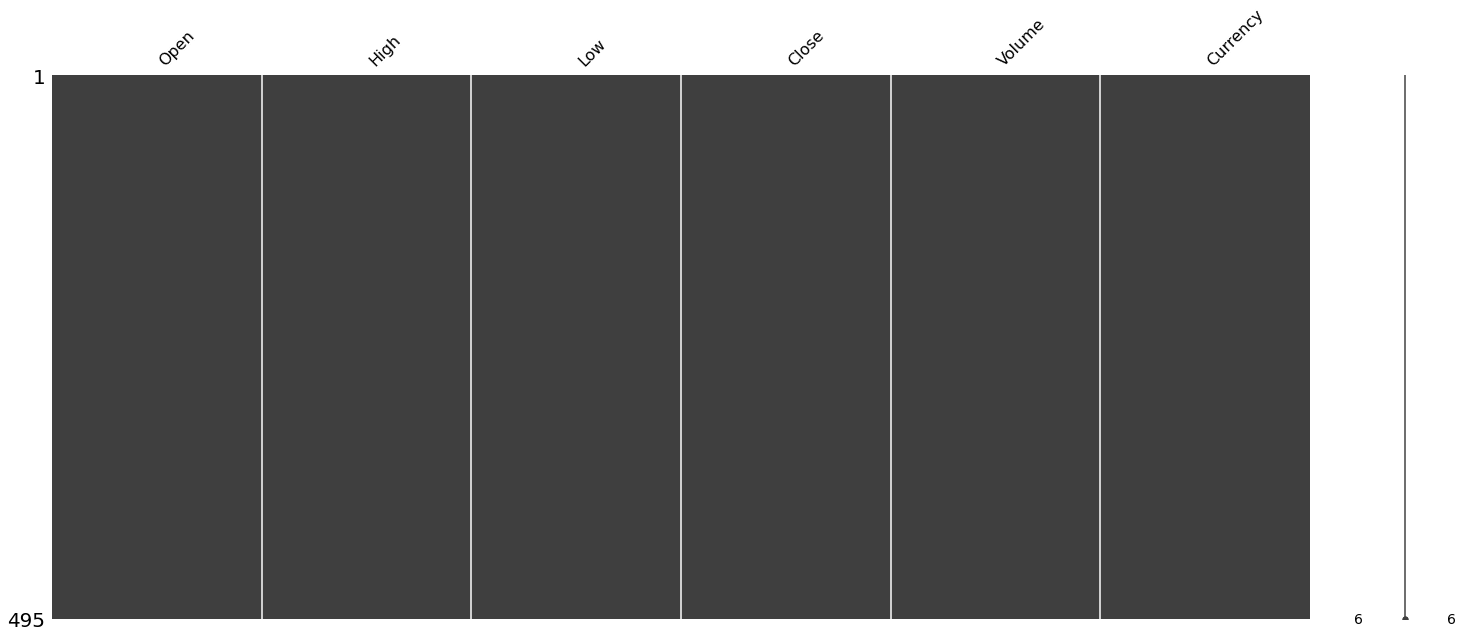

In [12]:
import missingno as msno
msno.matrix(df_otim)

In [13]:
CapitalInicial=[]

CapitalInicial.append(0.51748124) #IRBR3

CapitalInicial.append(0.23356792) #RENT3

CapitalInicial.append(0.07458088) #MGLU3

CapitalInicial.append(0.17436996) #JBSS3


In [14]:
QtdTrades=[]
Retornos=[]
retornos_aux=[]
melhor_short=0
melhor_long=0
melhor_retorno=0
intervalo_short=5
intervalo_long=30
valores_short=[]
valores_long=[]
for iteracao in tqdm(range(1,(intervalo_short*intervalo_long+1))):
    
    if (iteracao/intervalo_long) == int(iteracao/intervalo_long):
        short=int(iteracao/intervalo_long)
    else:
        short=int(iteracao/intervalo_long)+1
    
    long=iteracao-(intervalo_long*(short-1))+intervalo_short
    
    soma_retornos=0
    soma_retornosComprado=0
    soma_retornosVendido=0
    Quantidade_trades=0
    i2=0
    for stk in stocks:
        trades = pd.DataFrame(index=out_otim.index)
        trades['Close']=out_otim[stk].values


        trades['short'] = trades['Close'].rolling(window=short).mean()
        trades['long'] = trades['Close'].rolling(window=long).mean()
        
        
        trades['signalBuy']=0
        trades['signalSell']=0

 #       buy=0
 #       buyed=0
 #       sold=0
 #
 #       for day in range(1,len(trades)):
 #           if sold==False:
 #               if (trades['short'][day]>trades['long'][day]):
 #                   buy = 1  
 #               if buy == True:
 #                   if (trades['short'][day]<trades['long'][day]):
 #                       buy = 0
 #                   trades['signalBuy'][day]=buy

 #           if buy==False & trades['signalBuy'][day-1]==0:
 #               if (trades['short'][day]<trades['long'][day]):
 #                   sold = 1      
 #               if sold == True:
 #                   if (trades['short'][day]>trades['long'][day]):
 #                       sold = 0
 #                   trades['signalSell'][day]=sold

        #se estiver comprado no último dia vende
    
        buy=0
        buyed=0
        sold=0
        hold=False
        diasParado=0
        for day in range(1,len(trades)):
            if day>(diasParado+5):

                if sold==False & hold==False:
                    if (trades['short'][day]>trades['long'][day]):
                        buy = 1  
                    if buy == True:
                        if (trades['short'][day]<trades['long'][day]):
                            buy = 0
                            hold=True
                            diasParado=day
                        trades['signalBuy'][day]=buy

                if buy==False & hold==False:
                    if (trades['short'][day]<trades['long'][day]):
                        sold = 1      
                    if sold == True:
                        if (trades['short'][day]>trades['long'][day]):
                            sold = 0
                            hold=True
                            diasParado=day
                        trades['signalSell'][day]=sold
                hold=False

        if trades['signalBuy'][-1]==1 or trades['signalSell'][-1]==1:
            trades['signalBuy'][-1]=0
            trades['signalSell'][-1]=0

        # Posição dos trades
        trades['positionsBuy'] = trades['signalBuy'].diff()
        trades['positionsSell'] = trades['signalSell'].diff()
    
        pos_buy_buyed=np.where(trades['positionsBuy']==1)
        pos_sell_buyed=trades['positionsBuy']==-1
        days_buy_buyed=trades['Close'][trades['positionsBuy']==1].index
        days_sell_buyed=trades['Close'][trades['positionsBuy']==-1].index
        distance_buyed=days_sell_buyed-days_buy_buyed
        #
        pos_buy_sold=np.where(trades['positionsSell']==1)
        pos_sell_sold=trades['positionsSell']==-1
        days_buy_sold=trades['Close'][trades['positionsSell']==1].index
        days_sell_sold=trades['Close'][trades['positionsSell']==-1].index
        distance_sold=days_sell_sold-days_buy_sold
        #
        buy_trade=[]
        sell_trade=[]
        
        # Gráfico para comprado
        for i in range(len(days_buy_buyed)):
            values_2=trades['Close'][trades['Close'].index==(days_buy_buyed[i]+distance_buyed[i])].values[0]
            values_1=trades['Close'][trades['Close'].index==days_buy_buyed[i]].values[0]
            buy_trade.append(100*(values_2-values_1)/values_1)

        valuesbuy = np.array(buy_trade)
        values1buy=buy_trade
        
        #Gráfico para vendido
        for i in range(len(days_buy_sold)):
            values_2=trades['Close'][trades['Close'].index==(days_buy_sold[i]+distance_sold[i])].values[0]
            values_1=trades['Close'][trades['Close'].index==days_buy_sold[i]].values[0]
            sell_trade.append(100*(values_1-values_2)/values_1)

        valuessell = np.array(sell_trade)
        values1sell=sell_trade     
            
        a=1
        for kint in range(len(valuesbuy)):
            a*=((valuesbuy[kint]/100)+1)
        soma_retornosComprado+=(a*CapitalInicial[i2])

        b=1
        for kint in range(len(valuessell)):
            b*=((valuessell[kint]/100)+1)
        soma_retornosVendido+=(b*CapitalInicial[i2])

        soma_retornos+=((soma_retornosComprado*soma_retornosVendido)-1)

        i2+=1
        
        #Quantidade_trades=len(valuesbuy) + len(valuessell)
        
        
    #if iteracao==0:
     #   Retornos.append(-1000)
    
    Retornos.append(soma_retornos*100)
    valores_short.append(short)
    valores_long.append(long)
    retornos_aux=sorted(Retornos,reverse=True)
    
    #QtdTrades.append(Quantidade_trades)
    if retornos_aux[0]==(soma_retornos*100):
        melhor_short=short
        melhor_long=long
        melhor_retorno=soma_retornos*100
    
    
print(melhor_short,melhor_long,melhor_retorno)

  0%|          | 0/150 [00:00<?, ?it/s]<ipython-input-14-6ad27c7daa09>:76: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  trades['signalBuy'][day]=buy
<ipython-input-14-6ad27c7daa09>:86: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  trades['signalSell'][day]=sold
<ipython-input-14-6ad27c7daa09>:90: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  trades['signalBuy'][-1]=0
<ipython-input-14-6ad27c7daa09>:91: SettingWithCopyWarning: 
A value

5 35 43.74691835298252


Text(0.5, 0, 'Valor long')

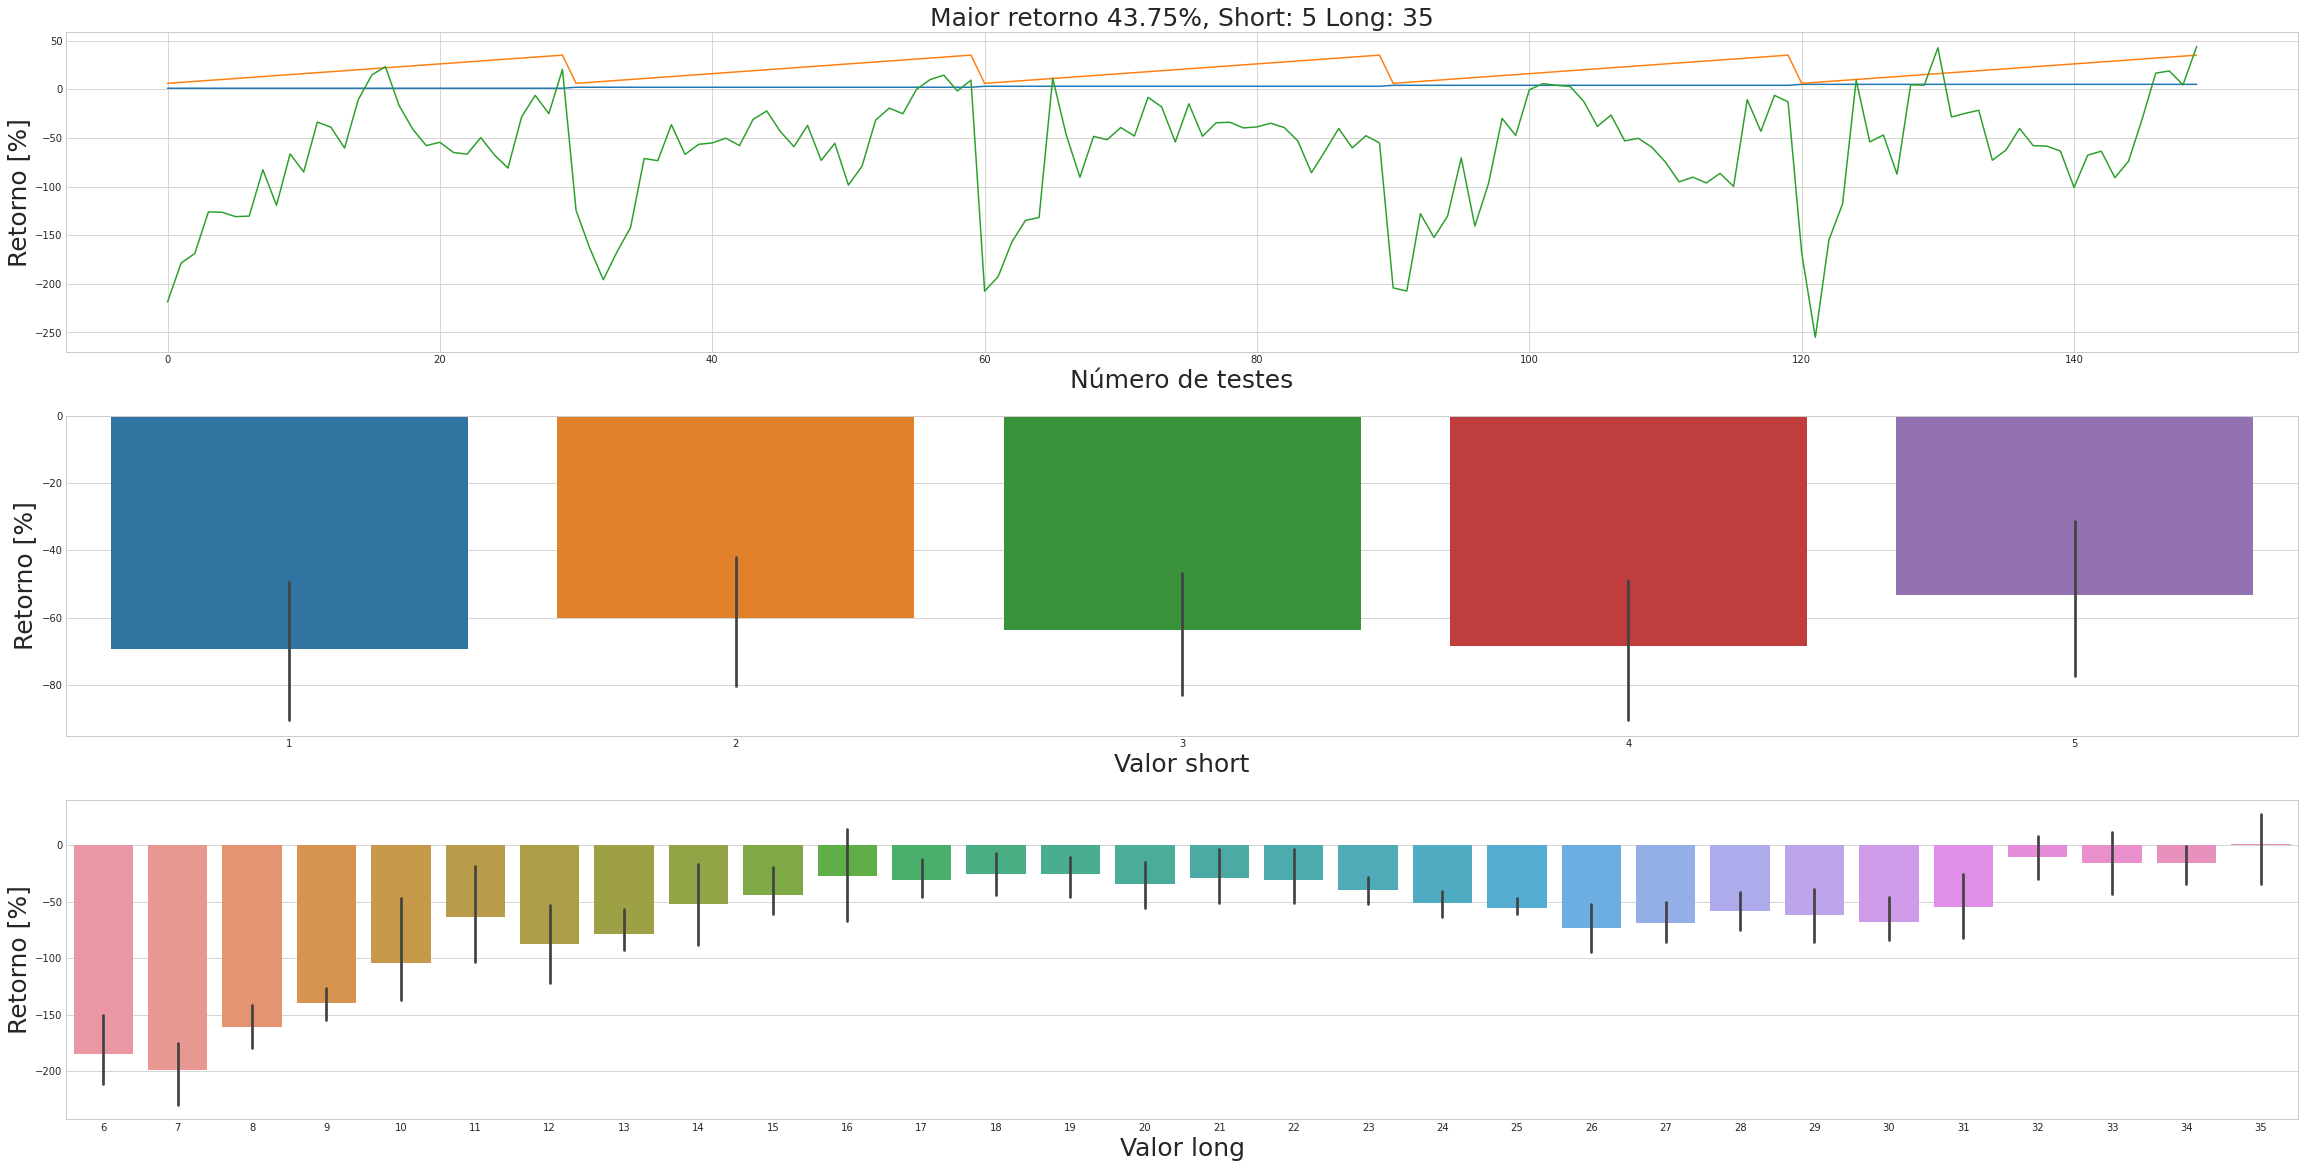

In [15]:
fig = plt.subplots(figsize=(40,20))
plt.style.use('seaborn-whitegrid')

ax1 = plt.subplot(311)
ax1.plot(valores_short, label='Short')
ax1.plot(valores_long, label='Long')
ax1.plot(Retornos, label='Retorno')
ax1.set_ylabel("Retorno [%]",fontsize=25)
ax1.set_xlabel("Número de testes",fontsize=25)
titulo="Maior retorno " + str(round(melhor_retorno,2)) + "%, " + "Short: " + str(melhor_short) + " Long: " + str(melhor_long)
ax1.set_title(titulo,fontsize=25)

ax2 = plt.subplot(312)
sns.barplot(x=valores_short, y=Retornos) 
ax2.set_ylabel("Retorno [%]",fontsize=25)
ax2.set_xlabel("Valor short",fontsize=25)

ax3 = plt.subplot(313)
sns.barplot(x=valores_long, y=Retornos) 
ax3.set_ylabel("Retorno [%]",fontsize=25)
ax3.set_xlabel("Valor long",fontsize=25)

Text(0.5, 0, 'Valor long')

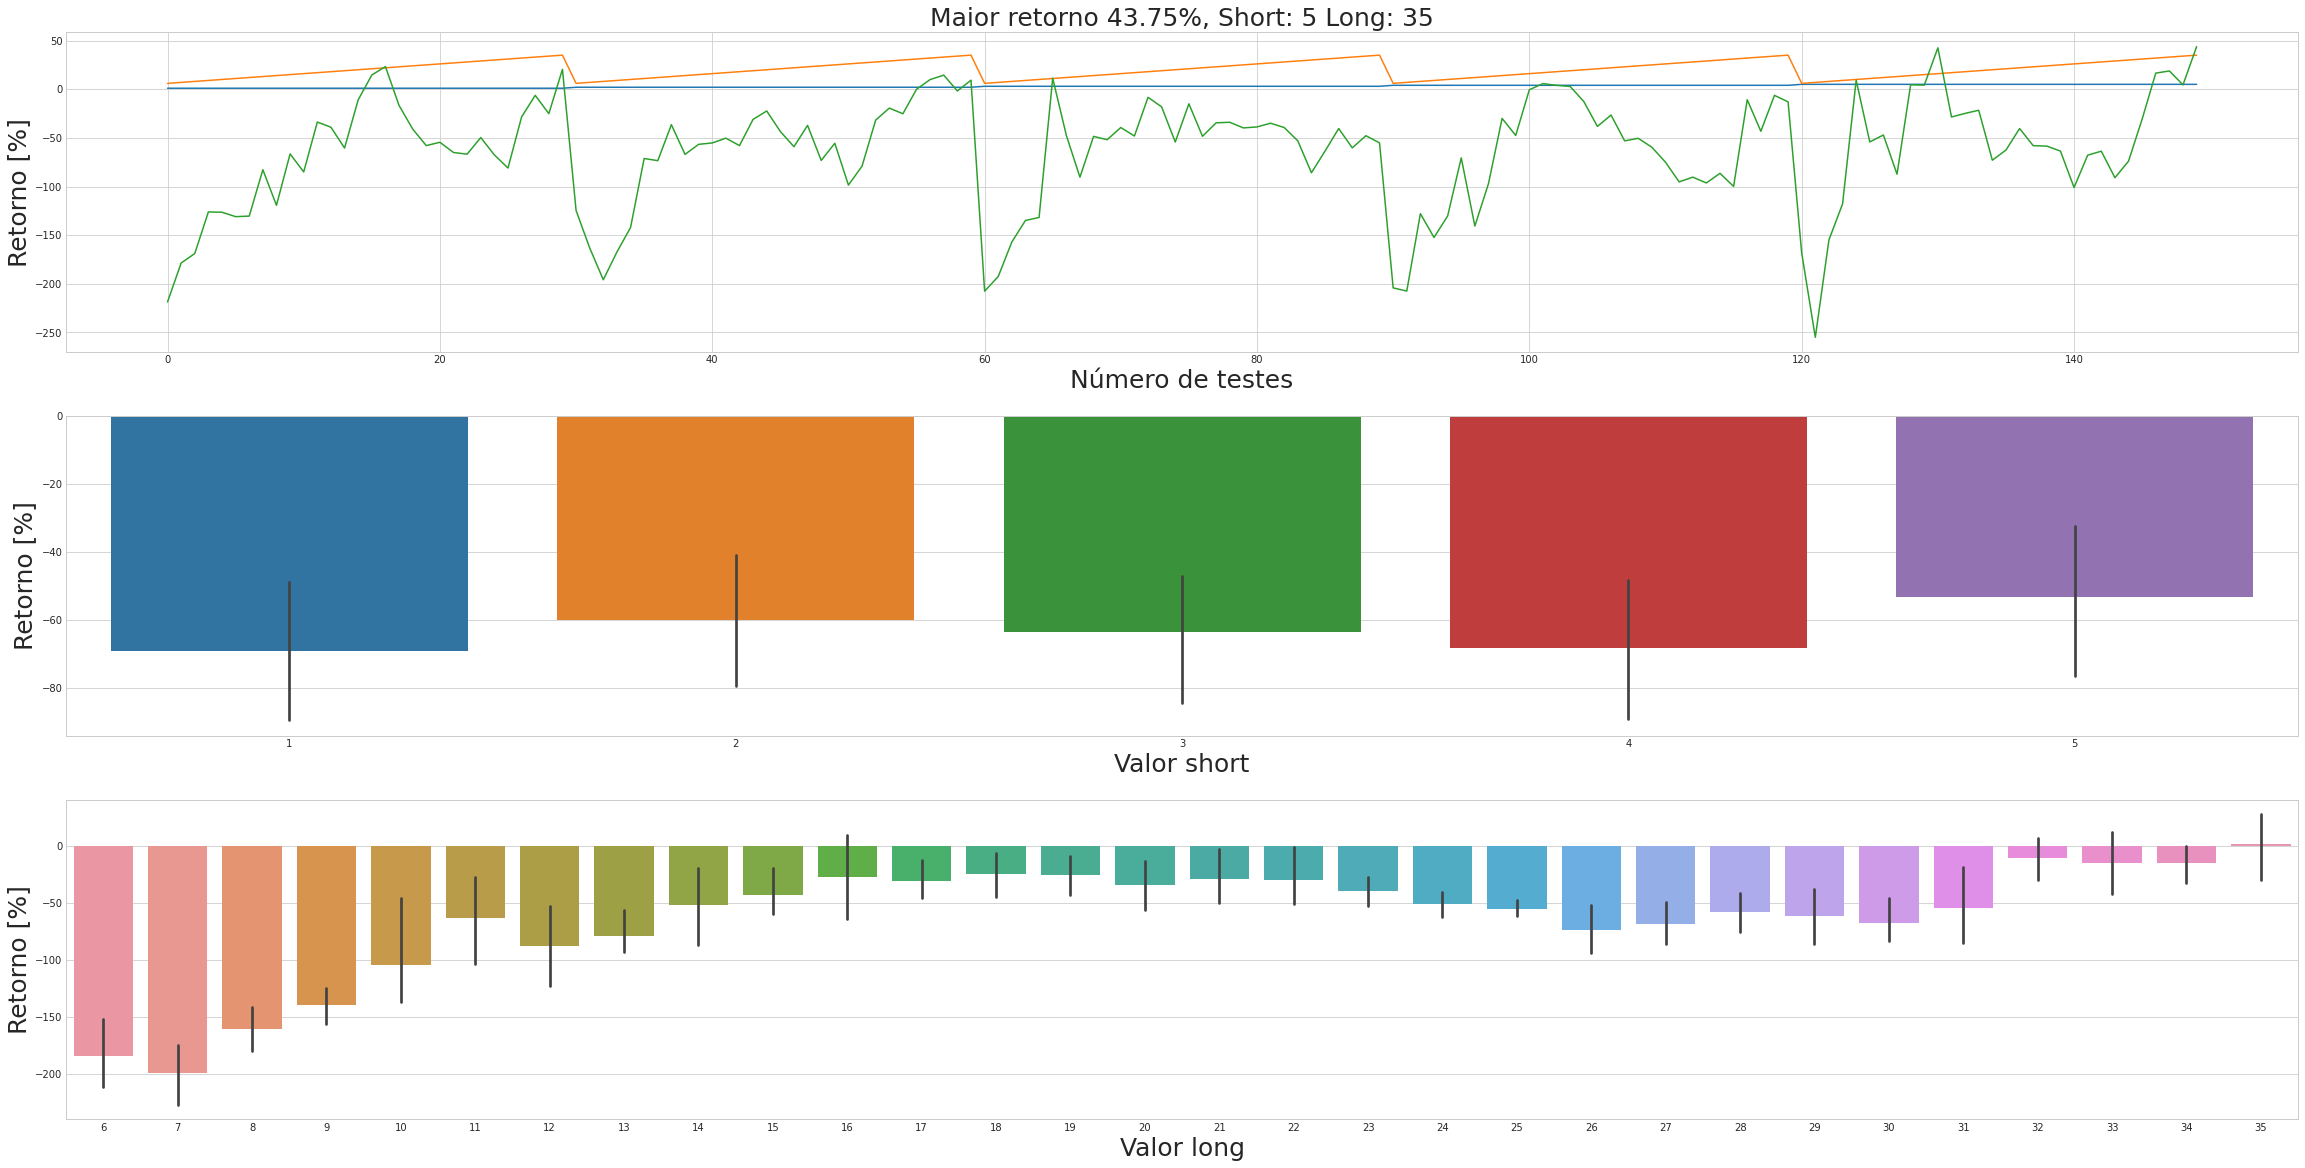

In [16]:
fig = plt.subplots(figsize=(40,20))
plt.style.use('seaborn-whitegrid')

ax1 = plt.subplot(311)
ax1.plot(valores_short, label='Short')
ax1.plot(valores_long, label='Long')
ax1.plot(Retornos, label='Retorno')
ax1.set_ylabel("Retorno [%]",fontsize=25)
ax1.set_xlabel("Número de testes",fontsize=25)
titulo="Maior retorno " + str(round(melhor_retorno,2)) + "%, " + "Short: " + str(melhor_short) + " Long: " + str(melhor_long)
ax1.set_title(titulo,fontsize=25)

ax2 = plt.subplot(312)
sns.barplot(x=valores_short, y=Retornos) 
ax2.set_ylabel("Retorno [%]",fontsize=25)
ax2.set_xlabel("Valor short",fontsize=25)

ax3 = plt.subplot(313)
sns.barplot(x=valores_long, y=Retornos) 
ax3.set_ylabel("Retorno [%]",fontsize=25)
ax3.set_xlabel("Valor long",fontsize=25)

Text(0.5, 0, 'Valor long')

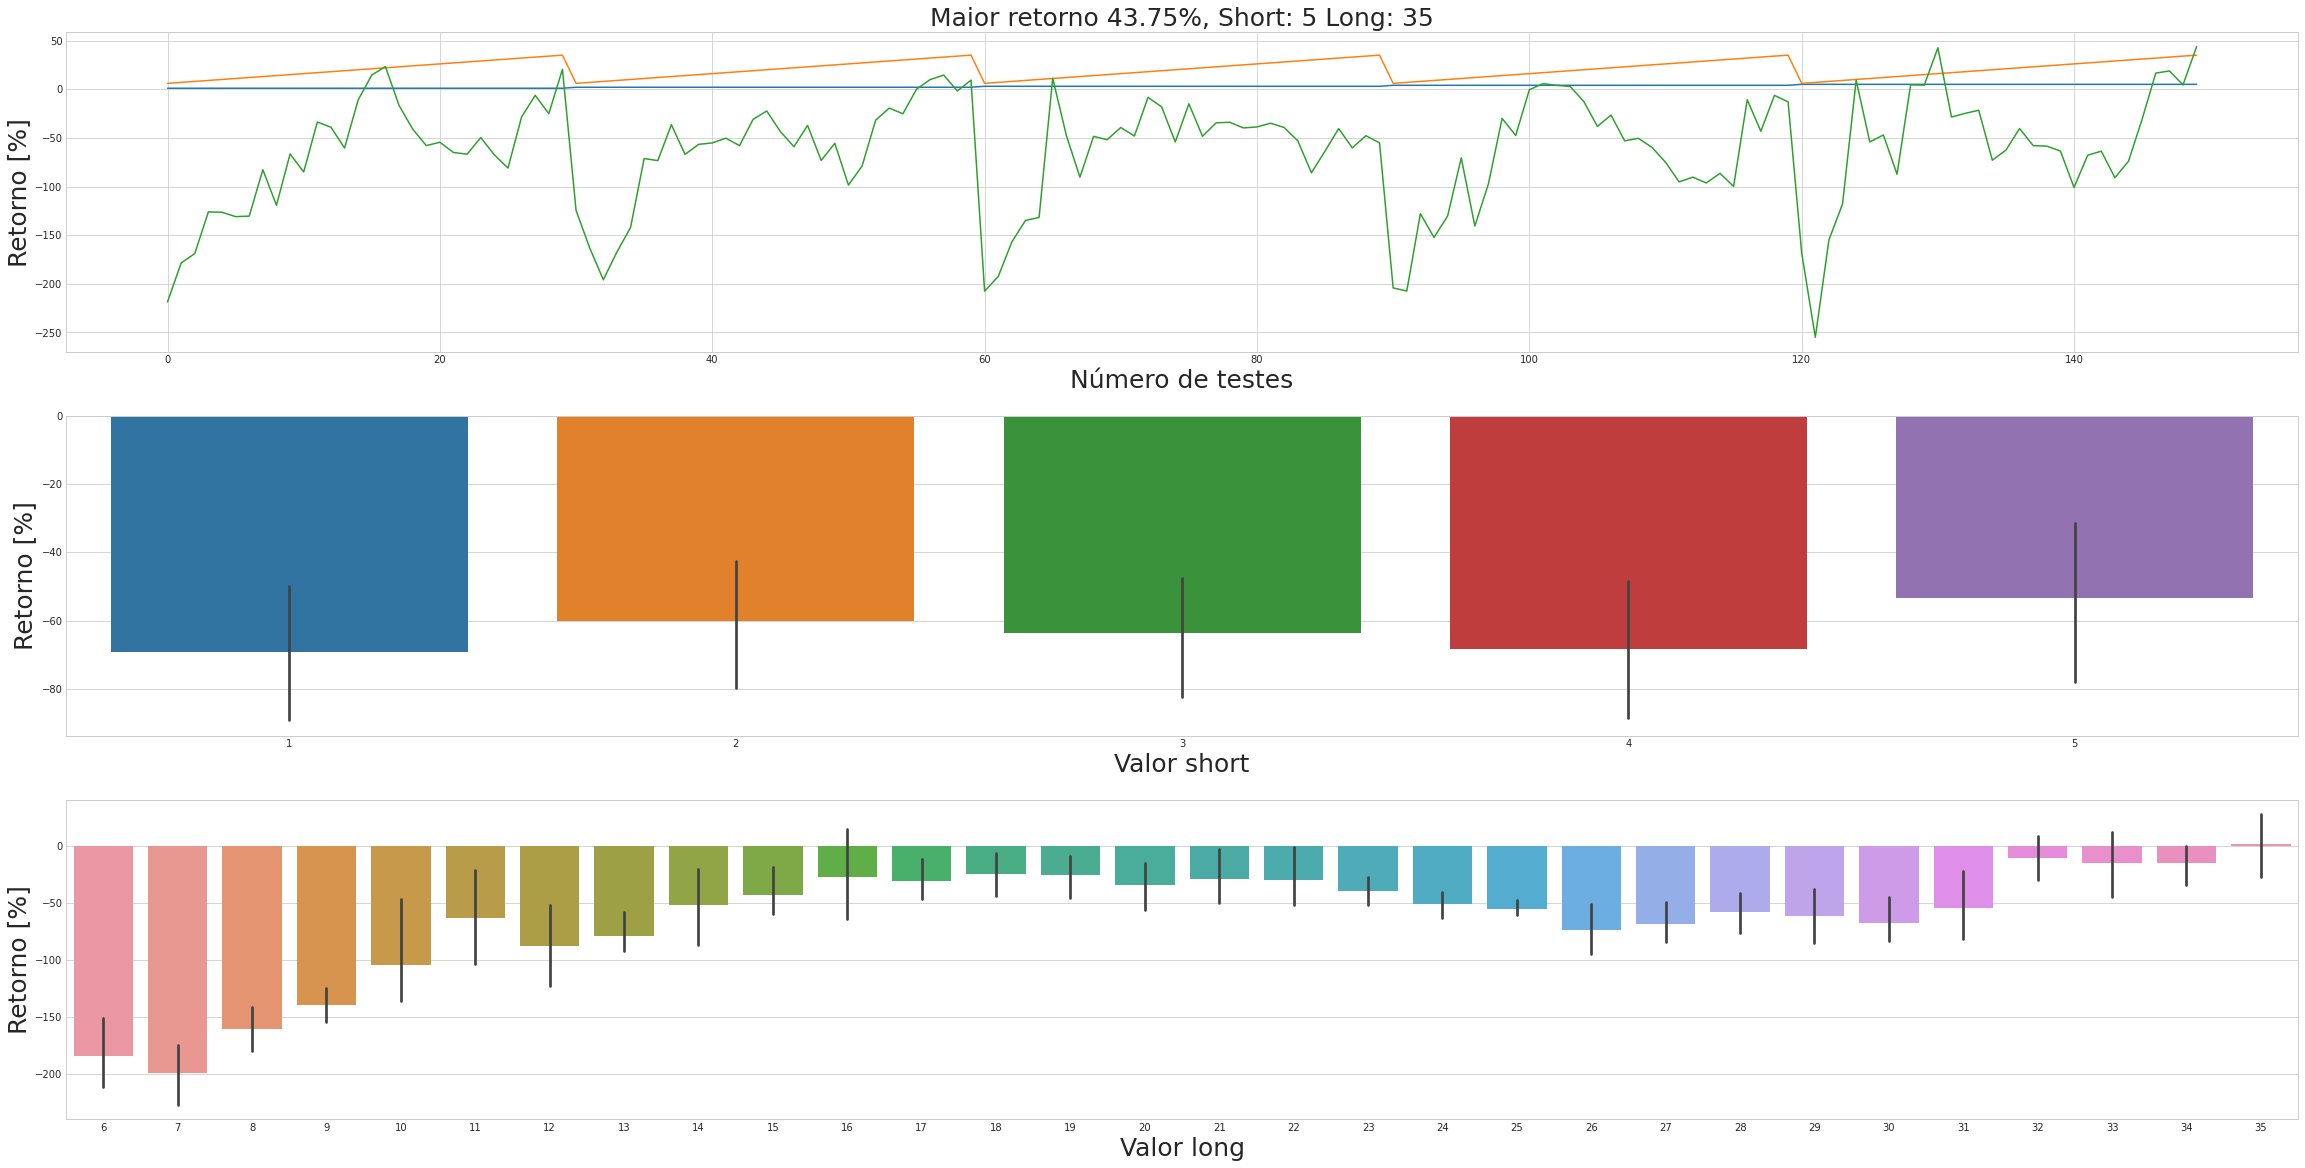

In [17]:
fig = plt.subplots(figsize=(40,20))
plt.style.use('seaborn-whitegrid')

ax1 = plt.subplot(311)
ax1.plot(valores_short, label='Short')
ax1.plot(valores_long, label='Long')
ax1.plot(Retornos, label='Retorno')
ax1.set_ylabel("Retorno [%]",fontsize=25)
ax1.set_xlabel("Número de testes",fontsize=25)
titulo="Maior retorno " + str(round(melhor_retorno,2)) + "%, " + "Short: " + str(melhor_short) + " Long: " + str(melhor_long)
ax1.set_title(titulo,fontsize=25)

ax2 = plt.subplot(312)
sns.barplot(x=valores_short, y=Retornos) 
ax2.set_ylabel("Retorno [%]",fontsize=25)
ax2.set_xlabel("Valor short",fontsize=25)

ax3 = plt.subplot(313)
sns.barplot(x=valores_long, y=Retornos) 
ax3.set_ylabel("Retorno [%]",fontsize=25)
ax3.set_xlabel("Valor long",fontsize=25)

<ipython-input-18-9e90a212e140>:42: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  trades['signalBuy'][day]=buy
<ipython-input-18-9e90a212e140>:52: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  trades['signalSell'][day]=sold
<ipython-input-18-9e90a212e140>:42: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  trades['signalBuy'][day]=buy
<ipython-input-18-9e90a212e140>:52: SettingWithCopyWarning: 
A value is trying to be set on a copy of a 

65.85206747323366 B3SA3
95.79549156449814 MGLU3
167.04309395118923 PRIO3
-3.83631576472121 JBSS3


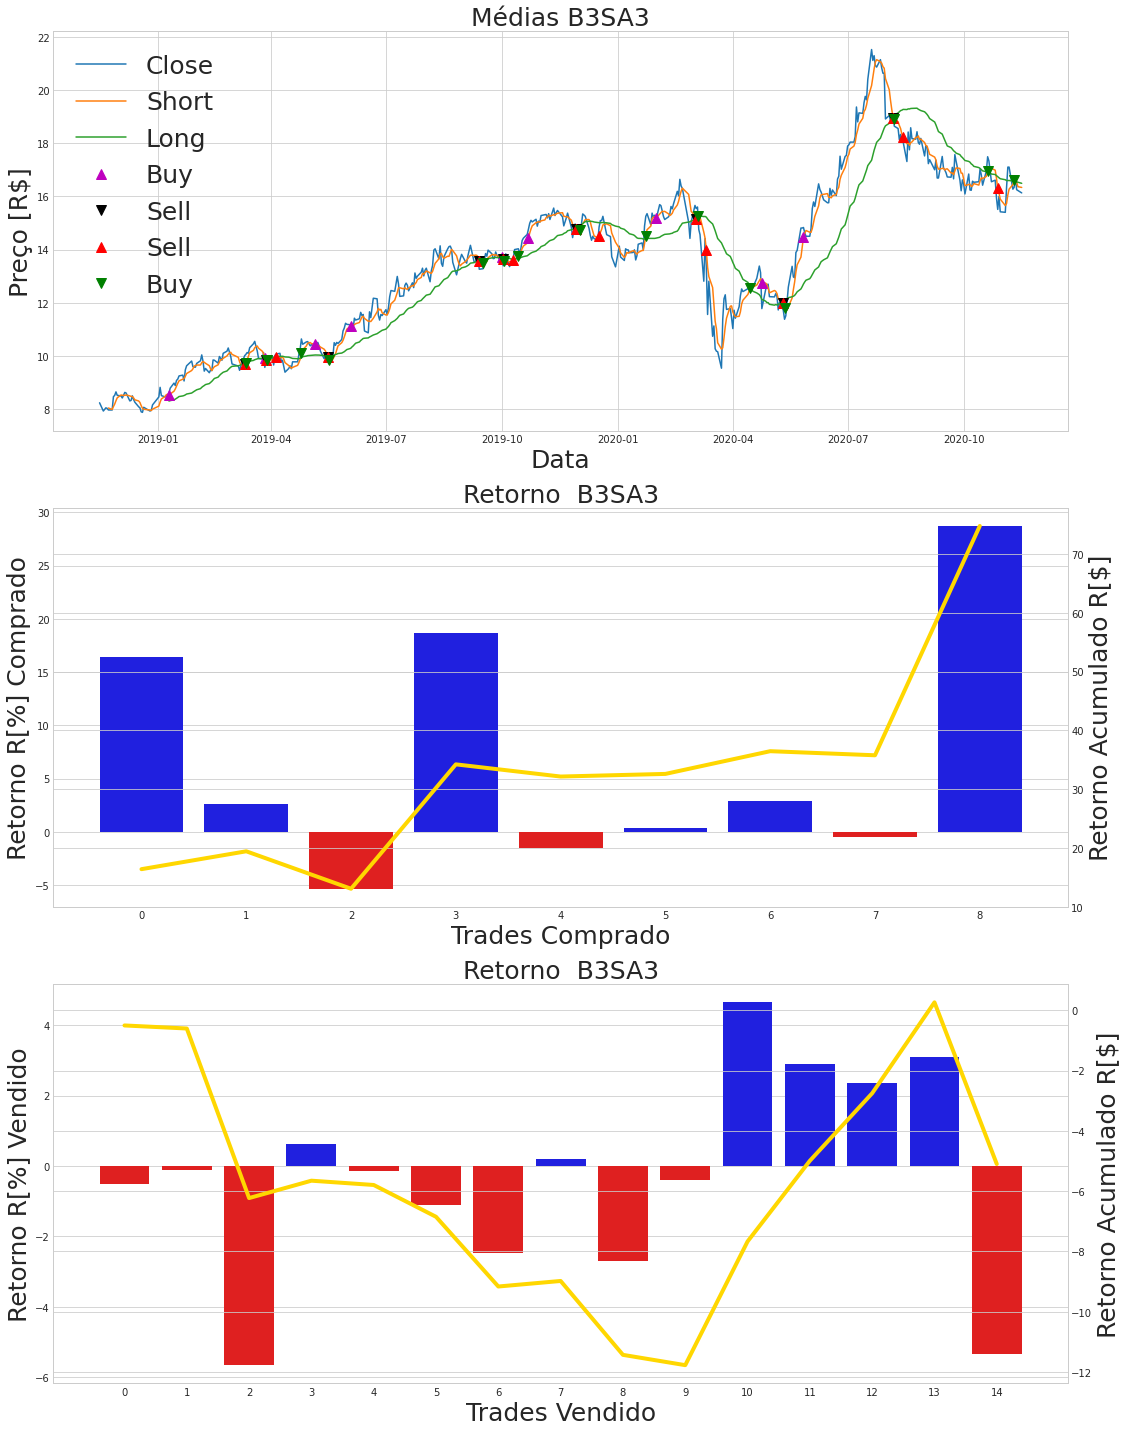

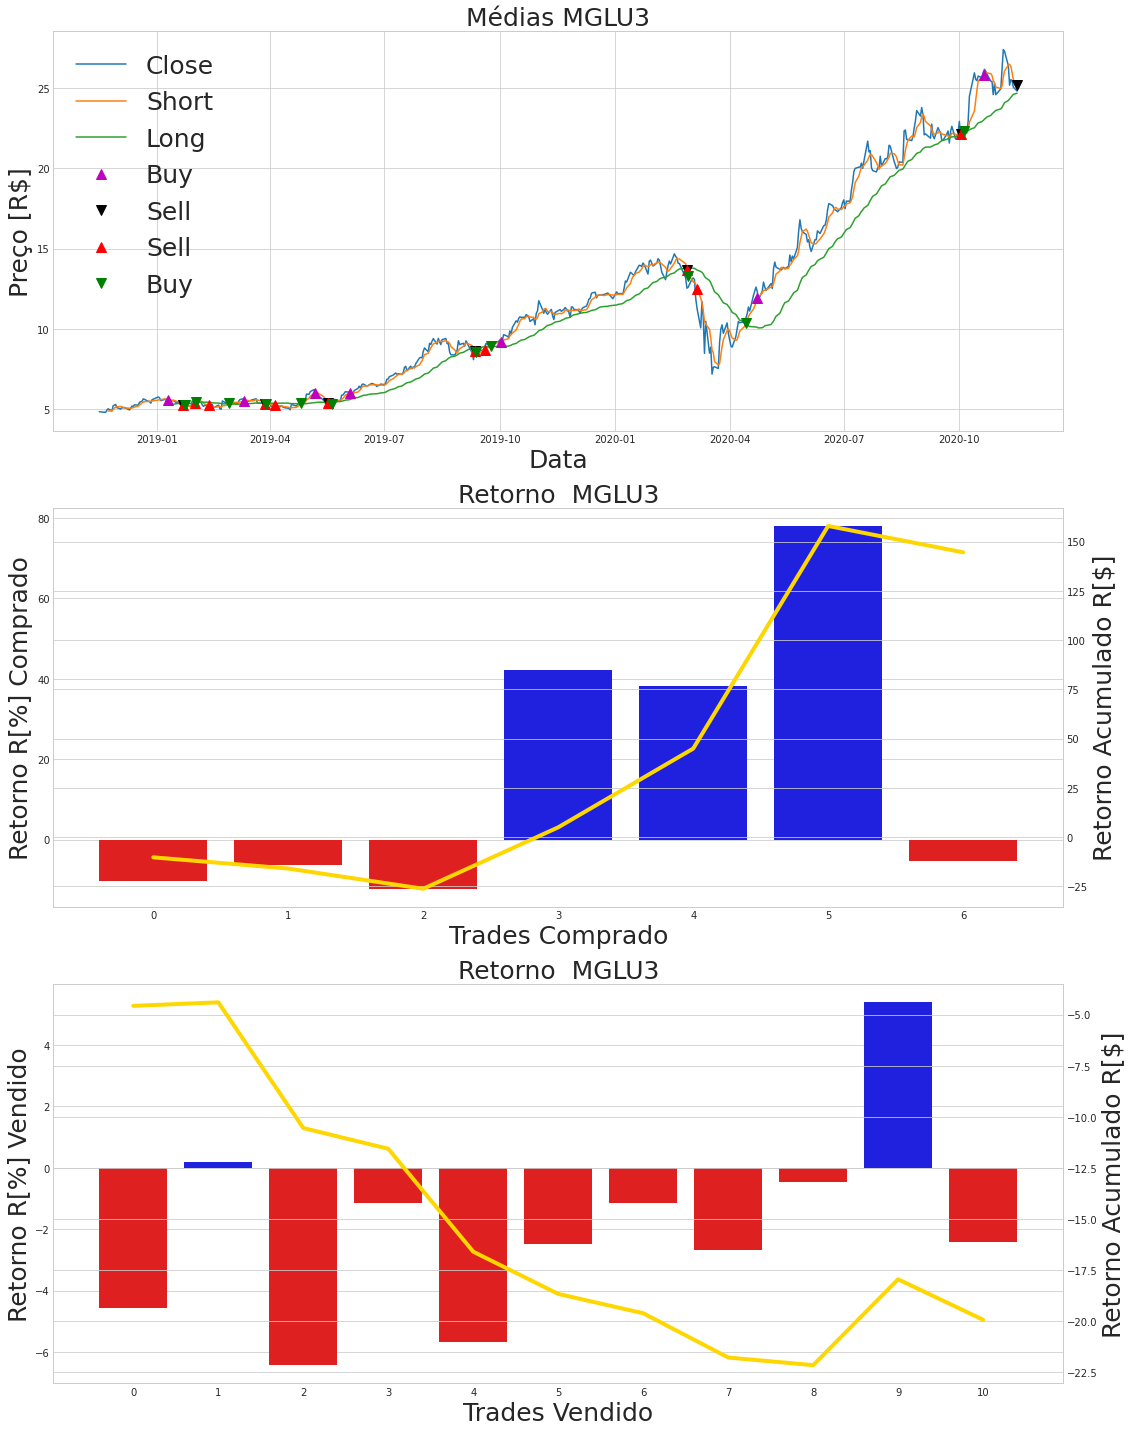

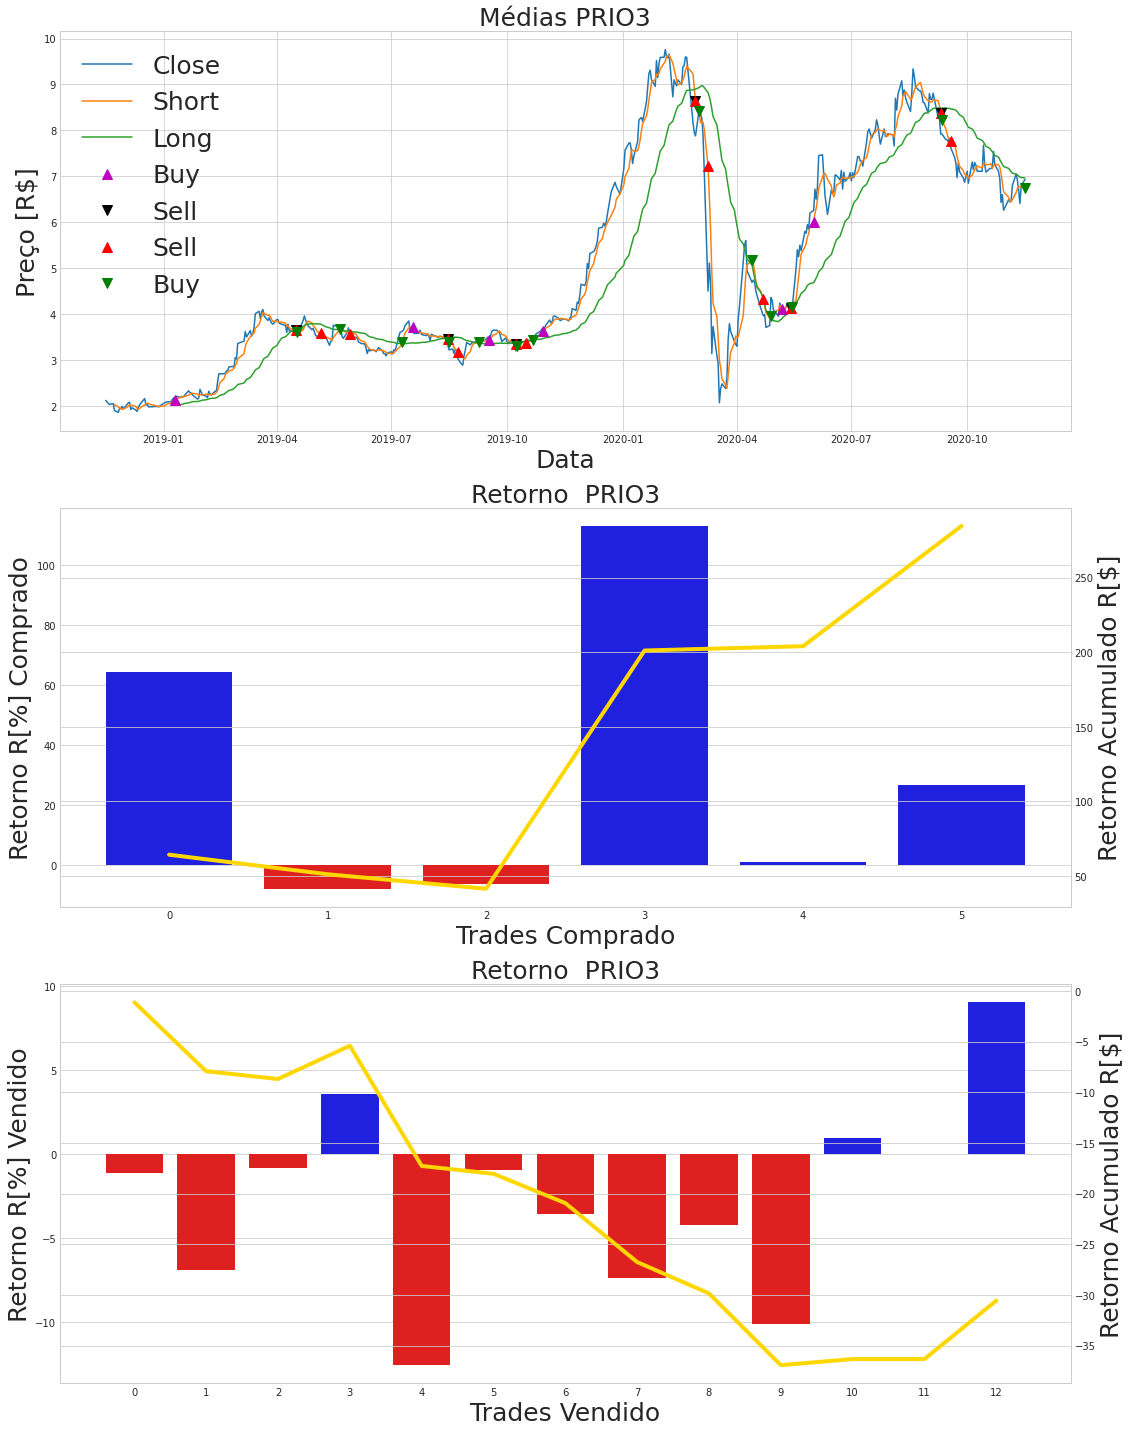

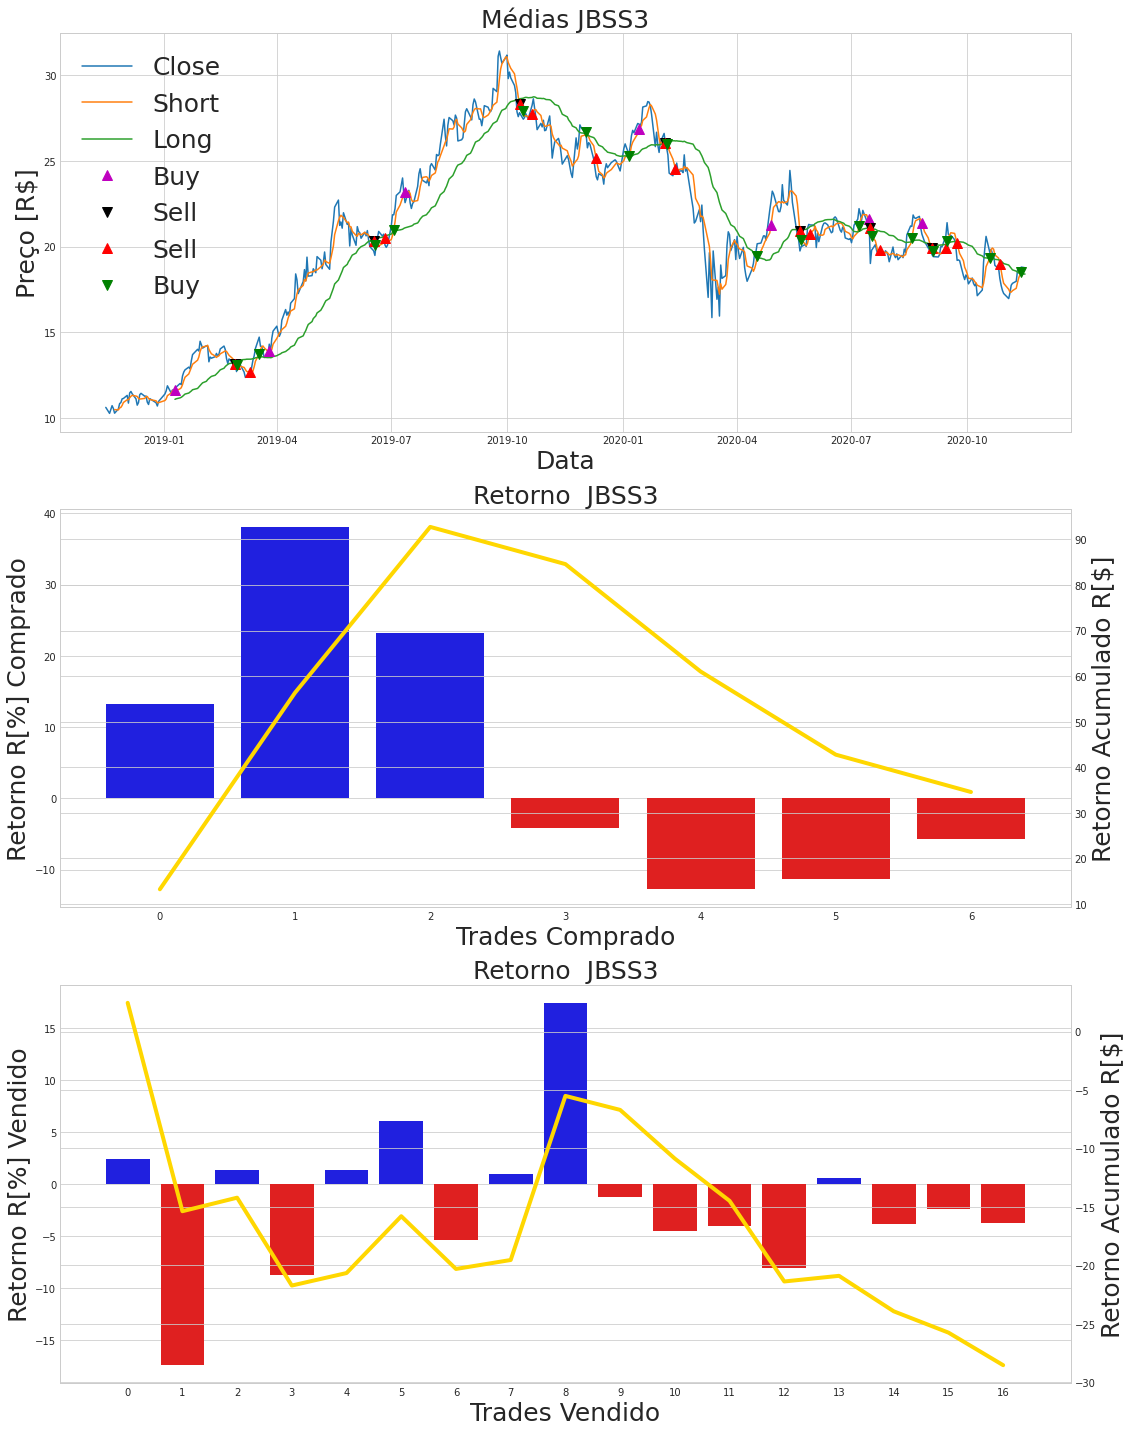

In [18]:
i12=0
soma_retornosA=0
soma_retornosB=0
aux=[]

taxa_acerto=0
num_trades=0

fator_lucro=1
ftr_pos=1
ftr_neg=1

for stk in stocks:
    trades = pd.DataFrame(index=out_otim.index)
    trades['Close']=out_otim[stk].values

    short=melhor_short
    long=melhor_long

    trades['short'] = trades['Close'].rolling(window=short).mean()
    trades['long'] = trades['Close'].rolling(window=long).mean()
    
    trades['signalBuy']=0
    trades['signalSell']=0

    buy=0
    buyed=0
    sold=0
    hold=False
    diasParado=0
    for day in range(1,len(trades)):
        if day>(diasParado+5):
            
            if sold==False & hold==False:
                if (trades['short'][day]>trades['long'][day]):
                    buy = 1  
                if buy == True:
                    if (trades['short'][day]<trades['long'][day]):
                        buy = 0
                        hold=True
                        diasParado=day
                    trades['signalBuy'][day]=buy

            if buy==False & hold==False:
                if (trades['short'][day]<trades['long'][day]):
                    sold = 1      
                if sold == True:
                    if (trades['short'][day]>trades['long'][day]):
                        sold = 0
                        hold=True
                        diasParado=day
                    trades['signalSell'][day]=sold
            hold=False
                
    #se estiver comprado no último dia vende

    if trades['signalBuy'][-1]==1 or trades['signalSell'][-1]==1:
        trades['signalBuy'][-1]=0
        trades['signalSell'][-1]=0

    # Posição dos trades
    trades['positionsBuy'] = trades['signalBuy'].diff()
    trades['positionsSell'] = trades['signalSell'].diff()
    
    fig = plt.subplots(figsize=(30,20))
    plt.style.use('seaborn-whitegrid')

    ax1 = plt.subplot(321)
    ax1.plot(trades['Close'], label='Close')
    ax1.plot(trades['short'], label='Short')
    ax1.plot(trades['long'],label='Long')

    ax1.plot(trades.loc[trades.positionsBuy == 1.0].index, 
             trades.short[trades.positionsBuy == 1.0],
             '^', markersize=10, color='m',label='Buy')
    ax1.plot(trades.loc[trades.positionsBuy == -1.0].index, 
             trades.short[trades.positionsBuy == -1.0],
             'v', markersize=10, color='k',label='Sell') 

    ax1.plot(trades.loc[trades.positionsSell == 1.0].index, 
             trades.short[trades.positionsSell == 1.0],
             '^', markersize=10, color='r',label='Sell')
    ax1.plot(trades.loc[trades.positionsSell == -1.0].index, 
             trades.short[trades.positionsSell == -1.0],
             'v', markersize=10, color='g',label='Buy') 


    ax1.set_ylabel("Preço [R$]",fontsize=25)
    ax1.set_xlabel("Data",fontsize=25)
    ax1.set_title("Médias" + " " + stk,fontsize=25)
    ax1.legend(loc='upper left',fontsize=25)

    ax5 = plt.subplot(323)
    #
    pos_buy_buyed=np.where(trades['positionsBuy']==1)
    pos_sell_buyed=trades['positionsBuy']==-1
    days_buy_buyed=trades['Close'][trades['positionsBuy']==1].index
    days_sell_buyed=trades['Close'][trades['positionsBuy']==-1].index
    distance_buyed=days_sell_buyed-days_buy_buyed
    #
    pos_buy_sold=np.where(trades['positionsSell']==1)
    pos_sell_sold=trades['positionsSell']==-1
    days_buy_sold=trades['Close'][trades['positionsSell']==1].index
    days_sell_sold=trades['Close'][trades['positionsSell']==-1].index
    distance_sold=days_sell_sold-days_buy_sold
    #
    buy_trade=[]
    sell_trade=[]
    # Gráfico para comprado
    for i in range(len(days_buy_buyed)):
        values_2=trades['Close'][trades['Close'].index==(days_buy_buyed[i]+distance_buyed[i])].values[0]
        values_1=trades['Close'][trades['Close'].index==days_buy_buyed[i]].values[0]
        buy_trade.append(100*(values_2-values_1)/values_1)

    valuesbuy = np.array(buy_trade)
    values1buy=buy_trade

    idx = np.array(list(range(len(buy_trade)))) 
    clrs = ['red' if (x < 0) else 'blue' for x in valuesbuy]
    sns.barplot(x=idx, y=valuesbuy, palette=clrs) 

    plt.ylabel('Retorno R[%] Comprado',fontsize=25)
    plt.xlabel('Trades Comprado',fontsize=25)

    ax52 = ax5.twinx()

    ax52.plot(sumper(valuesbuy),'gold',linewidth=4)

    plt.ylabel('Retorno Acumulado R[$]',fontsize=25)
    plt.xlabel('Trades',fontsize=25)
    plt.title('Retorno ' + " " + stk,fontsize=25)

    #Gráfico para vendido
    ax5segundo = plt.subplot(325)
    
    for i in range(len(days_buy_sold)):
        values_2=trades['Close'][trades['Close'].index==(days_buy_sold[i]+distance_sold[i])].values[0]
        values_1=trades['Close'][trades['Close'].index==days_buy_sold[i]].values[0]
        sell_trade.append(100*(values_1-values_2)/values_1)

    valuessell = np.array(sell_trade)
    values1sell=sell_trade

    idx = np.array(list(range(len(sell_trade)))) 
    clrs = ['red' if (x < 0) else 'blue' for x in valuessell]
    sns.barplot(x=idx, y=valuessell, palette=clrs) 

    plt.ylabel('Retorno R[%] Vendido',fontsize=25)
    plt.xlabel('Trades Vendido',fontsize=25)

    ax5segundo2 = ax5segundo.twinx()

    ax5segundo2.plot(sumper(valuessell),'gold',linewidth=4)

    plt.ylabel('Retorno Acumulado R[$]',fontsize=25)
    plt.xlabel('Trades',fontsize=25)
    plt.title('Retorno ' + " " + stk,fontsize=25)
    
    plt.tight_layout()
    
    a=1
    for kint in range(len(valuesbuy)):
        a*=((valuesbuy[kint]/100)+1)
        if valuesbuy[kint]>0:
            taxa_acerto+=1
            ftr_pos*=((valuesbuy[kint]/100)+1)
        else:
            ftr_neg*=((valuesbuy[kint]/-100)+1)
    soma_retornosA+=(a*CapitalInicial[i12])
    
    b=1
    for kint in range(len(valuessell)):
        b*=((valuessell[kint]/100)+1)
        if valuessell[kint]>0:
            taxa_acerto+=1
            ftr_pos*=((valuessell[kint]/100)+1)
        else:
            ftr_neg*=((valuessell[kint]/-100)+1)
    soma_retornosB+=(b*CapitalInicial[i12])
    
    aux.append(((a*b)-1)*100)
  
    i12+=1
    
    num_trades+=(len(valuesbuy)+len(valuessell))

for iteracao in range(len(aux)):
    print(aux[iteracao], stocks[iteracao])
    
taxa_acerto=(taxa_acerto/num_trades)*100

fator_lucro= ((ftr_pos-1)*100000)/((ftr_neg-1)*100000)

In [19]:
print(round(fator_lucro,2))

11.11


In [20]:
print("Taxa de acerto: {0}%" .format(round(taxa_acerto,2)))

Taxa de acerto: 40.0%


In [22]:
stocks=['IRBR3','RENT3','MGLU3', 'JBSS3']

out_teste = None

for stk in tqdm(stocks):

    df_teste = investpy.get_stock_historical_data(stock=stk,
                                            country='Brazil',
                                            from_date='16/11/2020',
                                            to_date='16/07/2021')

    if out_teste is None:
        out_teste=df_teste["Close"]
    else:
        out_teste=pd.concat([out_teste,df_teste["Close"]],axis=1)
out_teste.columns=stocks
out_teste.tail()

100%|██████████| 4/4 [00:02<00:00,  1.82it/s]


,IRBR3,RENT3,MGLU3,JBSS3
Date,,,,
2021-07-12,5.64,65.11,22.10,26.82
2021-07-13,5.57,65.17,22.49,26.89
2021-07-14,5.69,67.55,22.93,26.98
2021-07-15,5.59,67.68,23.72,26.54
2021-07-16,5.58,66.68,23.90,26.24


<AxesSubplot:>

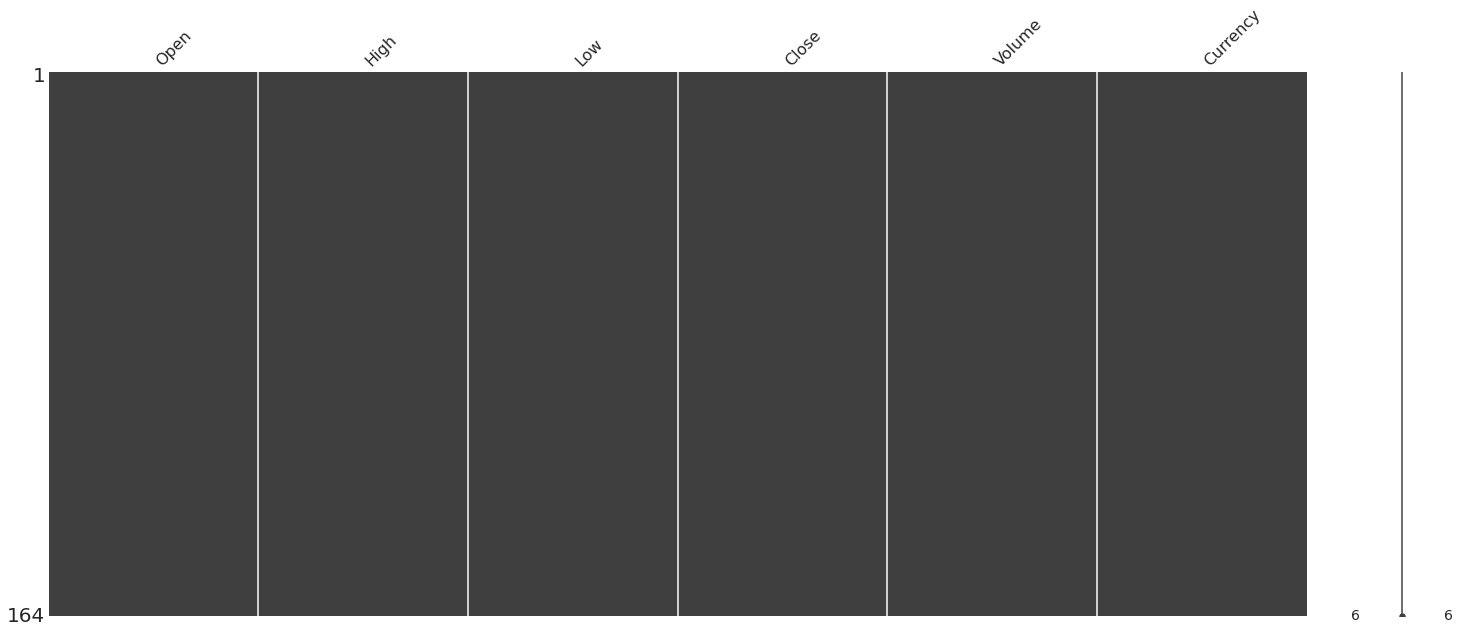

In [23]:
import missingno as msno
msno.matrix(df_teste)

<ipython-input-24-c48203daab82>:67: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  trades['signalBuy'][day]=buy
<ipython-input-24-c48203daab82>:77: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  trades['signalSell'][day]=sold
<ipython-input-24-c48203daab82>:83: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  trades['signalBuy'][-1]=0
<ipython-input-24-c48203daab82>:84: SettingWithCopyWarning: 
A value is trying to be set on a copy of a sli

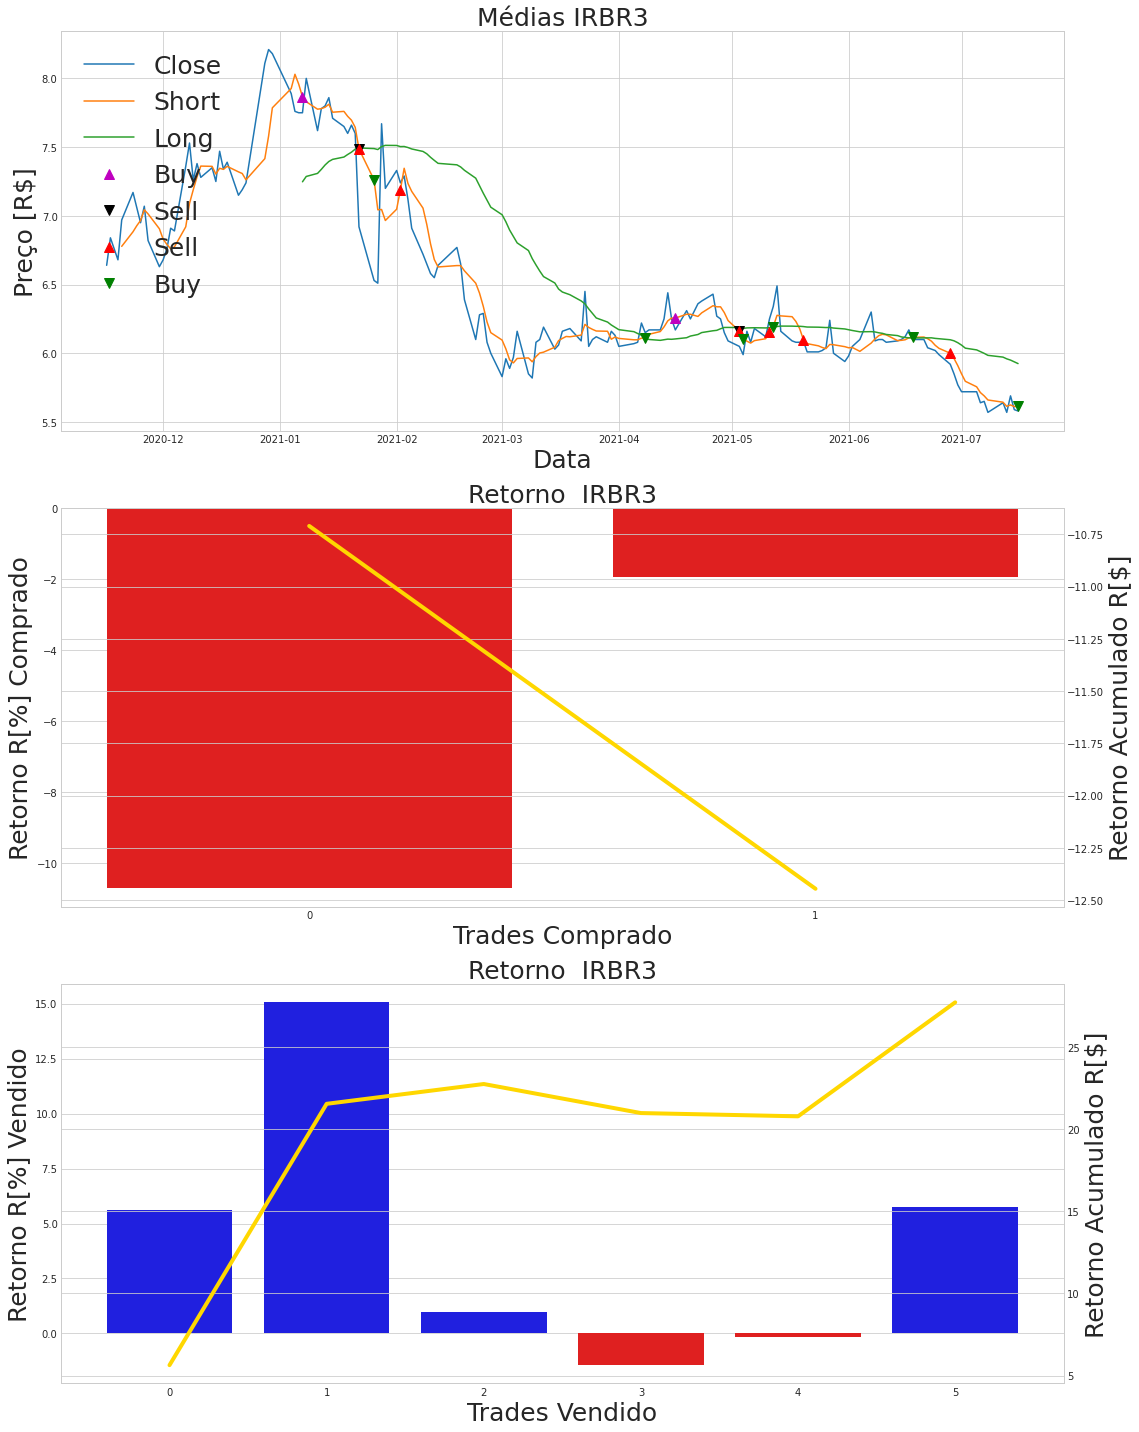

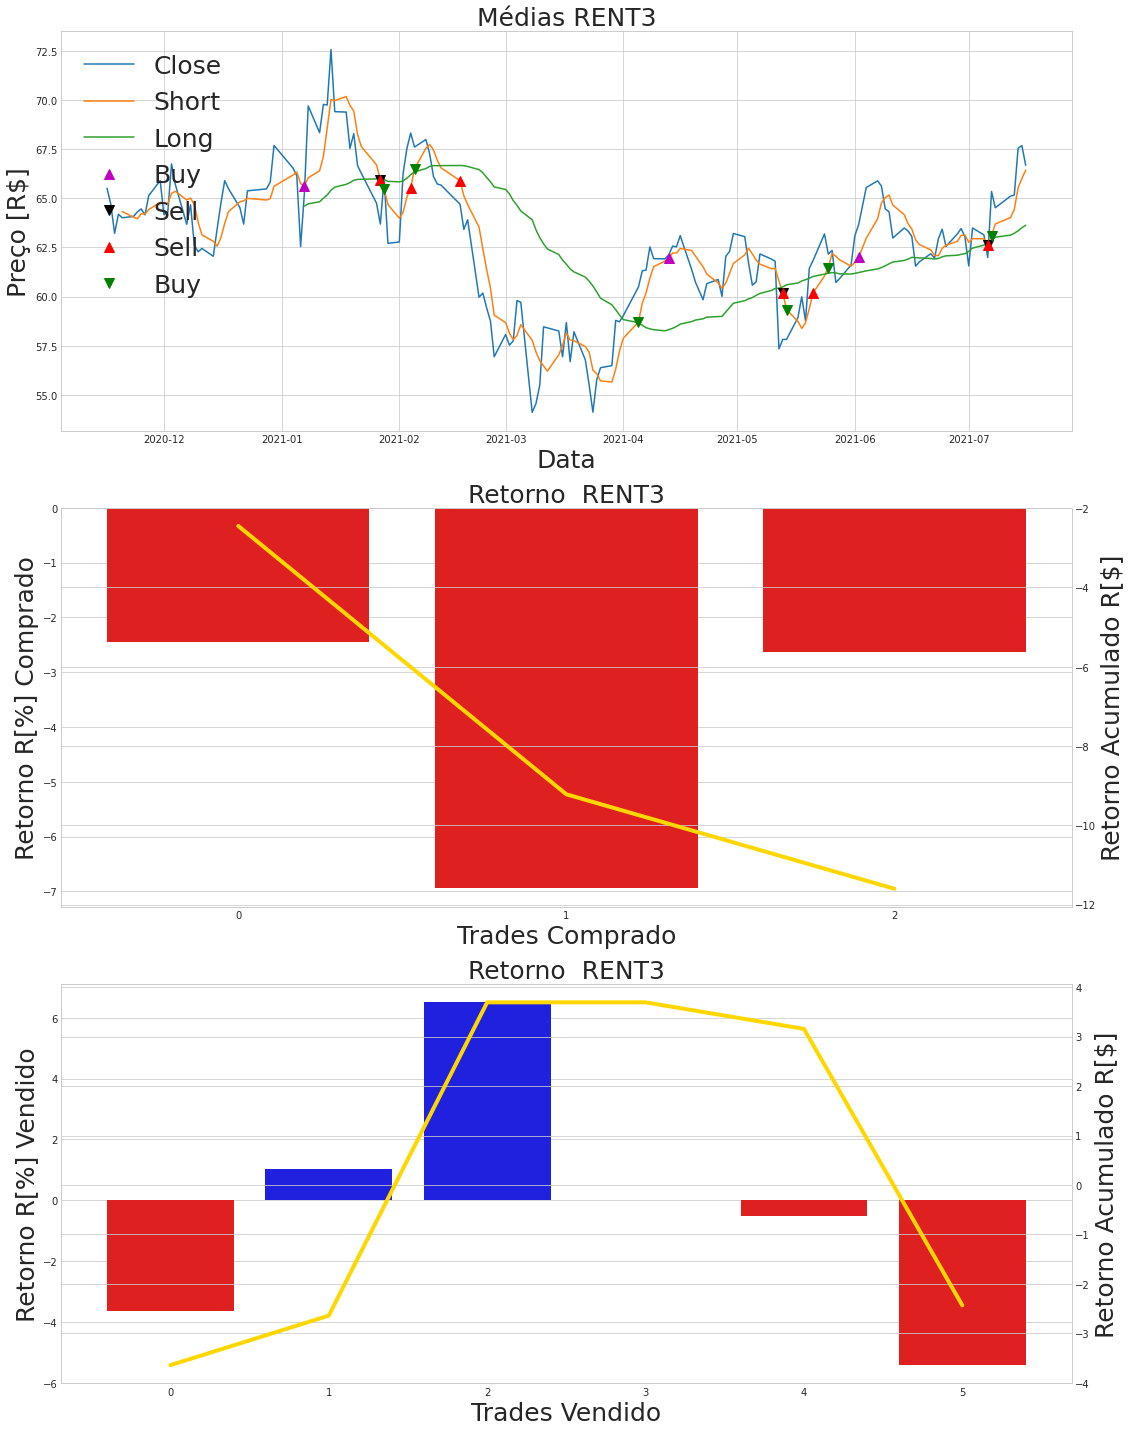

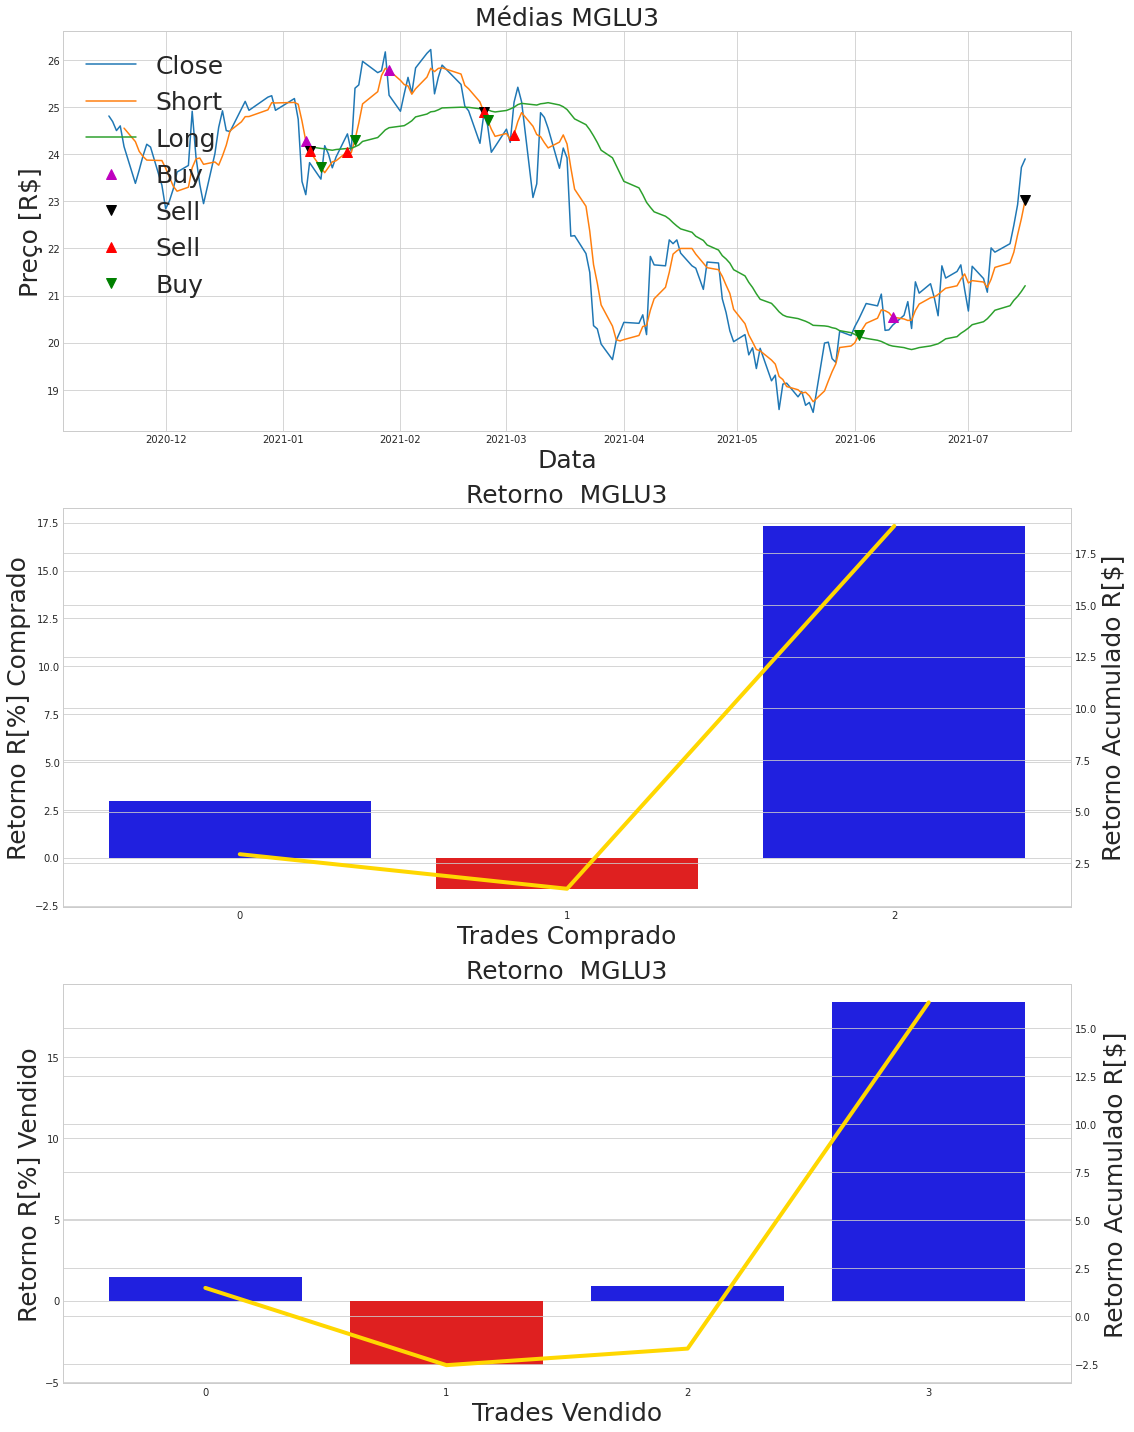

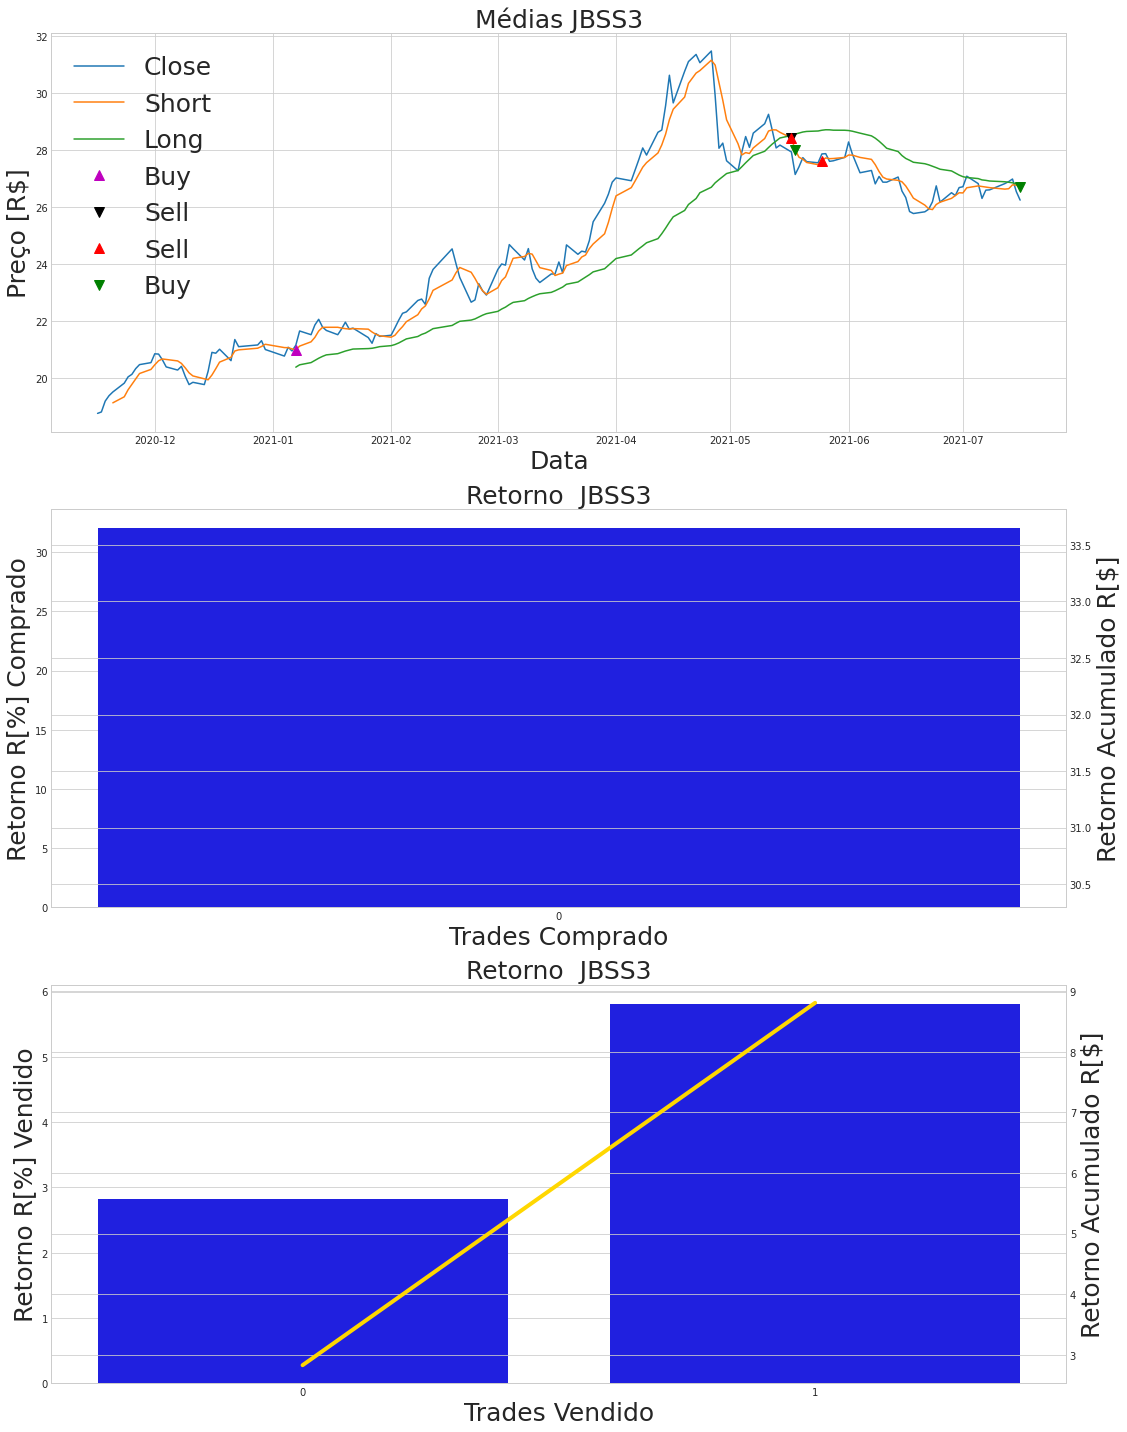

In [24]:
Trades=[]
Trades.append(0)
Trades.append(0)
Trades.append(0)
Trades.append(0)
i12=0
soma_retornosA=0
soma_retornosB=0

taxa_acerto=0
num_trades=0

fator_lucro=1
ftr_pos=1
ftr_neg=1

for stk in stocks:
    trades = pd.DataFrame(index=out_teste.index)
    trades['Close']=out_teste[stk].values

    short=melhor_short
    long=melhor_long
    
    trades['short'] = trades['Close'].rolling(window=short).mean()
    trades['long'] = trades['Close'].rolling(window=long).mean()
    
    trades['signalBuy']=0
    trades['signalSell']=0

 #   buy=0
 #   buyed=0
 #   sold=0
 #   
 #   for day in range(1,len(trades)):
 #       if sold==False:
 #           if (trades['short'][day]>trades['long'][day]):
 #               buy = 1  
 #           if buy == True:
 #               if (trades['short'][day]<trades['long'][day]):
 #                   buy = 0
 #               trades['signalBuy'][day]=buy
 #       
 #       if buy==False:
 #           if (trades['short'][day]<trades['long'][day]):
 #               sold = 1      
 #           if sold == True:
 #               if (trades['short'][day]>trades['long'][day]):
 #                   sold = 0
 #               trades['signalSell'][day]=sold
                
    buy=0
    buyed=0
    sold=0
    hold=False
    diasParado=0
    for day in range(1,len(trades)):
        if day>(diasParado+5):
            
            if sold==False & hold==False:
                if (trades['short'][day]>trades['long'][day]):
                    buy = 1  
                if buy == True:
                    if (trades['short'][day]<trades['long'][day]):
                        buy = 0
                        hold=True
                        diasParado=day
                    trades['signalBuy'][day]=buy

            if buy==False & hold==False:
                if (trades['short'][day]<trades['long'][day]):
                    sold = 1      
                if sold == True:
                    if (trades['short'][day]>trades['long'][day]):
                        sold = 0
                        hold=True
                        diasParado=day
                    trades['signalSell'][day]=sold
            hold=False
                
    #se estiver comprado no último dia vende

    if trades['signalBuy'][-1]==1 or trades['signalSell'][-1]==1:
        trades['signalBuy'][-1]=0
        trades['signalSell'][-1]=0

    # Posição dos trades
    trades['positionsBuy'] = trades['signalBuy'].diff()
    trades['positionsSell'] = trades['signalSell'].diff()
    
    fig = plt.subplots(figsize=(30,20))
    plt.style.use('seaborn-whitegrid')

    ax1 = plt.subplot(321)
    ax1.plot(trades['Close'], label='Close')
    ax1.plot(trades['short'], label='Short')
    ax1.plot(trades['long'],label='Long')

    ax1.plot(trades.loc[trades.positionsBuy == 1.0].index, 
             trades.short[trades.positionsBuy == 1.0],
             '^', markersize=10, color='m',label='Buy')
    ax1.plot(trades.loc[trades.positionsBuy == -1.0].index, 
             trades.short[trades.positionsBuy == -1.0],
             'v', markersize=10, color='k',label='Sell') 

    ax1.plot(trades.loc[trades.positionsSell == 1.0].index, 
             trades.short[trades.positionsSell == 1.0],
             '^', markersize=10, color='r',label='Sell')
    ax1.plot(trades.loc[trades.positionsSell == -1.0].index, 
             trades.short[trades.positionsSell == -1.0],
             'v', markersize=10, color='g',label='Buy') 


    ax1.set_ylabel("Preço [R$]",fontsize=25)
    ax1.set_xlabel("Data",fontsize=25)
    ax1.set_title("Médias" + " " + stk,fontsize=25)
    ax1.legend(loc='upper left',fontsize=25)

    ax5 = plt.subplot(323)
    #
    pos_buy_buyed=np.where(trades['positionsBuy']==1)
    pos_sell_buyed=trades['positionsBuy']==-1
    days_buy_buyed=trades['Close'][trades['positionsBuy']==1].index
    days_sell_buyed=trades['Close'][trades['positionsBuy']==-1].index
    distance_buyed=days_sell_buyed-days_buy_buyed
    #
    pos_buy_sold=np.where(trades['positionsSell']==1)
    pos_sell_sold=trades['positionsSell']==-1
    days_buy_sold=trades['Close'][trades['positionsSell']==1].index
    days_sell_sold=trades['Close'][trades['positionsSell']==-1].index
    distance_sold=days_sell_sold-days_buy_sold
    #
    buy_trade=[]
    sell_trade=[]
    # Gráfico para comprado
    for i in range(len(days_buy_buyed)):
        values_2=trades['Close'][trades['Close'].index==(days_buy_buyed[i]+distance_buyed[i])].values[0]
        values_1=trades['Close'][trades['Close'].index==days_buy_buyed[i]].values[0]
        buy_trade.append(100*(values_2-values_1)/values_1)

    valuesbuy = np.array(buy_trade)
    values1buy=buy_trade

    idx = np.array(list(range(len(buy_trade)))) 
    clrs = ['red' if (x < 0) else 'blue' for x in valuesbuy]
    sns.barplot(x=idx, y=valuesbuy, palette=clrs) 

    plt.ylabel('Retorno R[%] Comprado',fontsize=25)
    plt.xlabel('Trades Comprado',fontsize=25)

    ax52 = ax5.twinx()

    ax52.plot(sumper(valuesbuy),'gold',linewidth=4)

    plt.ylabel('Retorno Acumulado R[$]',fontsize=25)
    plt.xlabel('Trades',fontsize=25)
    plt.title('Retorno ' + " " + stk,fontsize=25)

    #Gráfico para vendido
    ax5segundo = plt.subplot(325)
    
    for i in range(len(days_buy_sold)):
        values_2=trades['Close'][trades['Close'].index==(days_buy_sold[i]+distance_sold[i])].values[0]
        values_1=trades['Close'][trades['Close'].index==days_buy_sold[i]].values[0]
        sell_trade.append(100*(values_1-values_2)/values_1)

    valuessell = np.array(sell_trade)
    values1sell=sell_trade

    idx = np.array(list(range(len(sell_trade)))) 
    clrs = ['red' if (x < 0) else 'blue' for x in valuessell]
    sns.barplot(x=idx, y=valuessell, palette=clrs) 

    plt.ylabel('Retorno R[%] Vendido',fontsize=25)
    plt.xlabel('Trades Vendido',fontsize=25)

    ax5segundo2 = ax5segundo.twinx()

    ax5segundo2.plot(sumper(valuessell),'gold',linewidth=4)

    plt.ylabel('Retorno Acumulado R[$]',fontsize=25)
    plt.xlabel('Trades',fontsize=25)
    plt.title('Retorno ' + " " + stk,fontsize=25)
    
    plt.tight_layout()
    
    a=1
    for kint in range(len(valuesbuy)):
        a*=((valuesbuy[kint]/100)+1)
        if valuesbuy[kint]>0:
            taxa_acerto+=1
            ftr_pos*=((valuesbuy[kint]/100)+1)
        else:
            ftr_neg*=((valuesbuy[kint]/-100)+1)
    soma_retornosA+=(a*CapitalInicial[i12])
    
    b=1
    for kint in range(len(valuessell)):
        b*=((valuessell[kint]/100)+1)
        if valuessell[kint]>0:
            taxa_acerto+=1
            ftr_pos*=((valuessell[kint]/100)+1)
        else:
            ftr_neg*=((valuessell[kint]/-100)+1)
    soma_retornosB+=(b*CapitalInicial[i12])
    
    #aux=((a*b)-1)
    aux=(a*b)
    
    patrimonio=[]
    patrimonio.append(CapitalInicial[i12]*100000)
    patrimonio.append(patrimonio[0]*aux)
    Trades[i12]=patrimonio
    
    num_trades+=(len(valuesbuy)+len(valuessell))
    
    i12+=1
    
taxa_acerto=(taxa_acerto/num_trades)*100

fator_lucro= ((ftr_pos-1)*100000)/((ftr_neg-1)*100000)

In [25]:
num_trades

27

In [26]:
print(round(fator_lucro,2))

3.9


In [27]:
print("Taxa de acerto: {0}%" .format(round(taxa_acerto,2)))

Taxa de acerto: 51.85%


In [28]:
numTrades=[a for a in range(len(Trades[0]))]
irbr3=pd.DataFrame(index=numTrades)
irbr3['Patrimonio IRBR3']=Trades[0]
#irbr3.loc[-1]=[(CapitalInicial[0]*100000)]
#irbr3.index=irbr3.index+1
#irbr3=irbr3.sort_index()


numTrades=[a for a in range(len(Trades[1]))]
rent3=pd.DataFrame(index=numTrades)
rent3['Patrimonio RENT3']=Trades[1]
#rent3.loc[-1]=[(CapitalInicial[1]*100000)]
#rent3.index=rent3.index+1
#rent3=rent3.sort_index()

numTrades=[a for a in range(len(Trades[2]))]
mglu3=pd.DataFrame(index=numTrades)
mglu3['Patrimonio MGLU3']=Trades[2]
#mglu3.loc[-1]=[(CapitalInicial[2]*100000)]
#mglu3.index=mglu3.index+1
#mglu3=mglu3.sort_index()

numTrades=[a for a in range(len(Trades[3]))]
jbss3=pd.DataFrame(index=numTrades)
jbss3['Patrimonio JBSS3']=Trades[3]
#jbss3.loc[-1]=[(CapitalInicial[3]*100000)]
#jbss3.index=jbss3.index+1
#jbss3=jbss3.sort_index()

<AxesSubplot:>

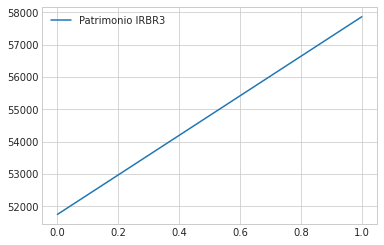

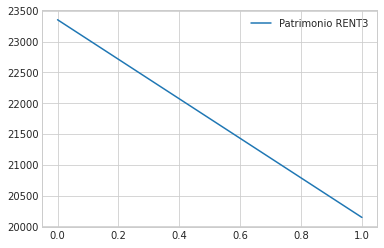

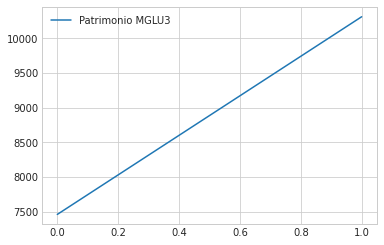

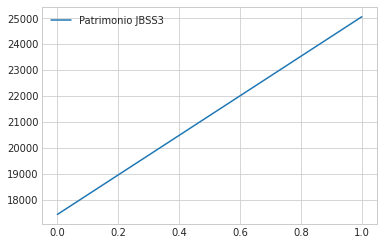

In [29]:
#ax1 = plt.subplot(321)
irbr3.plot()
#ax2 = plt.subplot(322)
rent3.plot()
#ax3 = plt.subplot(323)
mglu3.plot()
#ax4 = plt.subplot(324)
jbss3.plot()

In [31]:
patrimonio=0
for a in range(len(Trades)):
    patrimonio+=Trades[a][-1]
print("Patrimônio final: R$" + str(round(patrimonio,2)))

Patrimônio final: R$113375.4
